# E_vs_r_scan
- - -

**Lucas M. Hale**, [lucas.hale@nist.gov](mailto:lucas.hale@nist.gov?Subject=ipr-demo), *Materials Science and Engineering Division, NIST*.

**Chandler A. Becker**, [chandler.becker@nist.gov](mailto:chandler.becker@nist.gov?Subject=ipr-demo), *Office of Data and Informatics, NIST*.

**Zachary T. Trautt**, [zachary.trautt@nist.gov](mailto:zachary.trautt@nist.gov?Subject=ipr-demo), *Materials Measurement Science Division, NIST*.

Version: 2016-09-07

[Disclaimers](http://www.nist.gov/public_affairs/disclaimer.cfm) 
 
- - -

## 1. Introduction

The __E_vs_r_scan__ calculation creates a plot of the cohesive energy vs interatomic spacing, r, for a given atomic system. The system size is uniformly scaled (b/a and c/a ratios held fixed) and the energy is calculated at a number of sizes without relaxing the system. All box sizes corresponding to energy minima are identified. 

This calculation was created as a quick method for scanning the phase space of a crystal structure with a given potential in order to identify starting guesses for further structure refinement calculations.

__Disclaimer #1__: the minima identified by this calculation do not guarantee that the associated crystal structure will be stable as no relaxation is performed by this calculation. Upon relaxation, the atomic positions and box dimensions may transform the system to a different structure

__Disclaimer #2__: it is possible that the calculation may miss an existing minima for a crystal structure if it is ouside the range of r values scanned, or has b/a, c/a values far from the ideal.

## 2. Calculation Input File Parameters

The calculation's input file expects certain key terms.

### 2.1 Commands

Provides the external commands for running LAMMPS and MPI.

- __lammps_command__: the path to the executable for running LAMMPS on your system. Required.

- __mpi_command__: the command associated with calling LAMMPS to run in parallel on your system. Default value is None (run serially).

### 2.2 Potential

Provides the information associated with an interatomic potential implemented for LAMMPS.

- __potential_file__: the path to the LAMMPS-potential data model used by atomman to generate the proper LAMMPS commands for an interatomic potential. Required.
 
- __potential_dir__: the path to the directory containing any potential artifacts (eg. eam setfl files) that are used. Default is '' (working directory for the simulation.)

### 2.3 System Load

Provides the information associated with loading an atomic configuration.

- __load__: the style and path to the initial configuration file being read in. The style can be any file type supported by atomman.System.load(). Required.
 
- __load_options__: a list of key-value pairs for the optional arguments in atomman.System.load().
 
- __symbols__: a space-delimited list of atom-model symbols corresponding to the atom types and potential. If not given, the element/symbol information in the loaded file will be used. Required if the load file does not contain element/symbol information. 
 
- __box_parameters__: box parameters to scale the loaded system to. If not given, the box parameters of the loaded file are used. 
    
    - three floats: a b c.  Allows for the definintion of orthorhombic lattice parameters.
    
    - six floats: a b c alpha beta gamma.  Allows for the definition of the lattice parameters and angles.

__NOTE__: The absolute box_parameter a,b,c values don't matter for the E_vs_r_scan calculation, but the b/a and c/a ratios and angles will affect the calculation.
    
### 2.4 System Manipulations

Performs manipulations on the loaded system. 

- __x-axis, y-axis, z-axis__: optional transformation axes for rotating the system. Each vector is given by three space-delimited numbers.  The vectors must be orthogonal to each other.  If the loaded system is cubic these vectors are taken as hkl crystallographic directions and the rotated system is transformed into an orthorhombic box with dimensions given by a\*sqrt(h<sup>2</sup>+k<sup>2</sup>+l<sup>2</sup>) for each axis. 

- __shift__: optional positional shift that is applied to all atoms.  The shift is applied after axis rotation, but before size_mults supersizing.

- __shift_scale__: Boolean flag indicating if the shift is absolute (False), or should be scaled relative to the system's unit cell (True).

- __size_mults__: optional parameters for supersizing the system. This may either be a list of three or six integers.

    - Three integers: mx my mz. The absolute values indicate how many times the system is multiplied along a given box axes and the sign indicates the direction.  
    
    - Six integers: nx px ny py nz pz. This allows for multiplications in both directions for each box axis. The n terms must be less than or equal to zero, and the p terms greater than or equal to zero. 
    
### 2.5 Units

Specifies the units for various physical quantities to use in reading/writing values.

- __length_unit__: defines the unit of length for results, and input parameters if not specified. Default is 'angstrom'.

- __energy_unit__: defines the unit of energy for results, and input parameters if not specified. Default is 'eV'.

- __pressure_unit__: defines the unit of pressure for results, and input parameters if not specified. Default is 'GPa'.

- __force_unit__: defines the unit of pressure for results, and input parameters if not specified. Default is 'eV/angstrom'.

### 2.6 Run Parameters

Provides parameters specific to the calculation at hand.

- __minimum_r__: specifies the minimum interatomic spacing, r, for the scan. Default value is '2.0 angstrom'.

- __maximum_r__: specifies the maximum interatomic spacing, r, for the scan. Default value is '6.0 angstrom'.

- __number_of_steps_r__: specifies the number of interatomic spacing values, r, to use. Default value is 200.

## 3. Prepare Function Parameters

The input parameters recognized by the calculation's prepare function correspond to the calculation file input parameters with a few exceptions. Each parameter term can be specified with a list of values, with certain limitations placed on some parameters.

### 3.1 Additional terms:

These are additional terms that affect how the calculations are prepared.

- __run_directory__: the path to the directory where the calculation instances are being prepared. Required.

- __lib_directory__: the path to the directory where all XML results records are being stored. Required.

- __copy_files__: Boolean indicating if all required files for the calculation are copied into the calculation instance's folder or only the calculation script and input file. __Note__: runner.py currently requires copy_files to be True. Default value is True.

- __load_elements__: List of elements to use with the loaded system. User-specified wildcards are allowed. One or more symbols lists are generated from this based on the potential used.

### 3.2 Unused terms:

These are terms allowed by the calculation that are ignored by the prepare function.

- __x-axis, y-axis, z-axis__: Either won't affect results or will cause ambiguous problems.

- __shift__: won't affect results

- __symbols__: generated using load_elements.

### 3.3 Limitations

- __run_directory, lib_directory, copy_files, lammps_command, mpi_command, length_unit, pressure_unit, energy_unit, force_unit, minimum_r, maximum_r, number_of_steps_r__: are limited to single values.

- __potential_file, potential_dir__: must have the same number of values.

- __load, load_options, load_elements, box_parameters__: must have the same number of values.

## 4. Demonstration

### 4.1 Setup

#### Library Imports

In [1]:
#Standard Python imports
import os
import sys
import shutil
import glob
import subprocess

#External library imports
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from DataModelDict import DataModelDict as DM
import numpy as np
import atomman.unitconvert as uc

#### Specify iprPy directory

This Notebook accesses files and tools contained within the iprPy framework. They require that the entire iprPy be downloaded from GitHub and stored in an accessible location.

In [2]:
#This specifies the iprPy directory relative to the Notebook's default location.
iprPy_dir = os.path.abspath(os.path.join('..', '..'))

#import iprPy if installed to Python
try: 
    import iprPy

#import iprPy if not installed to Python   
except:
    sys.path.append(iprPy_dir)
    import iprPy

#### Fill in parameter dictionary

Make any blank terms empty strings.

In [3]:
input_params = {

    #Commands
    'lammps_command': 'lmp_serial',             
    'mpi_command':    '',                

    #Potential
    'potential_file': os.path.join(iprPy_dir, 'reference-libraries', 'potentials', '1999--Mishin-Y--Al.json'),
    'potential_dir':  os.path.join(iprPy_dir, 'reference-libraries', 'potentials', '1999--Mishin-Y--Al'),

    #System Load
    'load':           'system_model ' + os.path.join(iprPy_dir, 'reference-libraries', 'prototypes', 'A1--Cu--fcc.json'),
    'load_options':   '',         
    'symbols':        'Al',
    'box_parameters': '',

    #System Manipulations
    'x-axis':     '',                     
    'y-axis':     '',                     
    'z-axis':     '',                     
    'shift':      '',                     
    'size_mults': '3 3 3',               

    #Units
    'length_unit':   '',              
    'pressure_unit': '',             
    'energy_unit':   '',                
    'force_unit':    '',                

    #Run Parameters
    'minimum_r':         '2.0',          
    'maximum_r':         '6.0',          
    'number_of_steps_r': '200'}

### 3. Generate Calculation Instance

A calculation instance consists of the calculation script, template LAMMPS input files, and an input file with all parameters. 

#### 3.1 Working Directory

In [4]:
#Specify working directory
working_dir = 'E_vs_r_scan'

#Check if a relative working_dir matches the current directory's name.
#This ensures that recursive directories are not created if this cell is called multiple times.
cwd = os.path.basename(os.getcwd())
if cwd != working_dir:

    #Move to working_dir and create if needed
    working_dir = os.path.abspath(working_dir)
    try:
        os.chdir(working_dir)
    except:
        os.makedirs(working_dir)
        os.chdir(working_dir)

#### 3.2 Copy Calculation files

In [5]:
calc_files = os.path.join(iprPy_dir, 'iprPy', 'calculations', 'E_vs_r_scan', 'calc_files', '*')

for fname in glob.iglob(calc_files):
    shutil.copy(fname, os.getcwd())

#### 3.3 Fill in calculation template

In [6]:
with open('calc_E_vs_r_scan.template') as f:
    template = f.read()

with open('calc_E_vs_r_scan.in', 'w') as f:
    f.write('\n'.join(iprPy.tools.fill_template(template, input_params, '<', '>')))

### 4. Run Calculation

In [12]:
subprocess.call(['python', 'calc_E_vs_r_scan.py', 'calc_E_vs_r_scan.in'])

1

### 5. Display Results

Read results.json

In [8]:
with open('results.json') as f:
    results = DM(f)

Read in values and convert to Angstroms and eV

In [9]:
rvals = uc.value_unit(results.find('r'))
evals = uc.value_unit(results.find('cohesive-energy'))

rvals = uc.get_in_units(rvals, 'angstrom')
evals = uc.get_in_units(evals, 'eV')

Plot

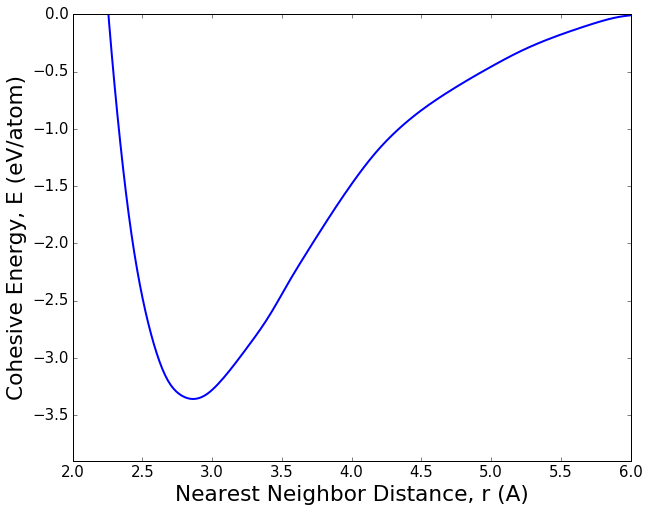

In [11]:
#Initial plot setup
matplotlib.rc('lines',lw=2)
matplotlib.rc('font',size=15)
plt.figure(figsize=(10,8))

#Plot data
plt.plot(rvals, evals, lw=2)   
        
#Final plot setup and show
plt.xlabel('Nearest Neighbor Distance, r (A)', size='x-large')
plt.ylabel('Cohesive Energy, E (eV/atom)', size='x-large')
plt.ylim(round(min(evals), 1)-.5, 0.0)
plt.xlim(min(rvals), max(rvals))
plt.show()